In [1]:
import math # to initialize minimum to infinity
from collections import defaultdict # dictionary of lists
import numpy as np # for generating random weights in large graph
import matplotlib.pyplot as plt
import matplotlib.image as mpimg  # to show graph
import random

In [95]:
def initialize_population(list_nodes, pop_size):
    population = []
    number_of_node = len(list_nodes)
    for i in range(pop_size):
        chromosome = []
        while len(chromosome)!=number_of_node:
            rand_node = np.random.randint(number_of_node)
            if rand_node not in chromosome:
                chromosome.append(rand_node)
        population.append(chromosome)
    return population

In [234]:
def cal_fitness(graph_edges,chromosome):
    total_cost=0
    i=1
    while i<len(chromosome):
        for temp_edge in graph_edges:
            if chromosome[i-1]==temp_edge[0] and chromosome[i]==temp_edge[1]:
                total_cost=total_cost+temp_edge[2]
        i=i+1
    for temp_edge in graph_edges:
            if chromosome[0]==temp_edge[0] and chromosome[len(chromosome) - 1]==temp_edge[1]:
                total_cost=total_cost+temp_edge[2]
    return total_cost

In [235]:
def selection(population,graph_edges,k):
    costs = []
    selected_parent = []
    pop_fitness = []
    for i in range(len(population)):
        costs.append(cal_fitness(graph_edges,population[i]))
        print(population[i])
        pop_fitness.append((costs[i],population[i]))
    #sort according to path_costs
    pop_fitness.sort(key = lambda x: x[0])
    # select only top elite_size fittest chromosomes in the population
    for i in range(k):
        selected_parent.append(pop_fitness[i][1])
    print(pop_fitness[0][0])
    return selected_parent,pop_fitness[0][0],selected_parent[0]

In [236]:
def breed(dad, mom):
    
    # let's say to breed from dad and mom (0,1,2,3,4) and (1,3,2,0,4)
    # if we choose dad(0-2) i.e (0,1,2) then we have to choose (3,4) from mom
    # i.e we have to create two children from two parents which are disjoint w.r.t each other
    child = []
    childP1 = []
    childP2 = []
    
    #select two random numbers between range(0,len(parents)) which are used as index
    geneA = int(random.random() * len(dad))
    geneB = int(random.random() * len(dad))
    
    #define start and end index to select child1 from dad
    if geneA < geneB :
        startGene, endGene = geneA, geneB
    else :
        endGene, startGene = geneA, geneB

    #add parent1(startGene,endGene) to child1
    for i in range(startGene, endGene):
        childP1.append(dad[i])
    
    #add mom to child2 if mom not in child1
    childP2 = [item for item in mom if item not in childP1]

    #create new child using disjoint Child1 and Child2
    child = childP1 + childP2
    return child

def crossover(top_k_elite, pop_size):
    children = []
    temp = np.array(top_k_elite)
    number_of_parents = temp.shape[0]
    #create new population of size pop_size from previous population
    for i in range(pop_size):
        #choose random parents
        random_dad = top_k_elite[np.random.randint(low =0,high = number_of_parents - 1)]
        random_mom = top_k_elite[np.random.randint(low =0,high = number_of_parents - 1)]
        #create child using random parents
        children.append(breed(random_dad,random_mom))
    return children

In [237]:
def mutate(chromosome, n_mutations):
    # we cannot randomly change a node from chromosome to another node
    # as this will create repeated nodes
    # we define mutation as mutation of edges in the path i.e swapping of nodes in the chromosome
    temp_parent = np.array(chromosome)
    size1 = temp_parent.shape[0]
    for i in range(n_mutations):
        # choose random indices to swap nodes in a chromosome
        rand1 = np.random.randint(0,size1)
        rand2 = np.random.randint(0,size1)
        # if rand1 and rand2 are same, then chromosome won't be mutated
        # so change rand2
        if rand1 == rand2:
            rand2=(rand2+1)%size1
        chromosome[rand1],chromosome[rand2]=chromosome[rand2],chromosome[rand1]
    return chromosome

def mutate_population(population,n_mutations):
    mutated_population = []
    for chromosome in population:
        mutated_chromosome = mutate(chromosome, n_mutations)
        mutated_population.append(mutated_chromosome)
    return mutated_population

In [262]:
# Graph  class represent all cities that sale_man travel
class Graph:

    def __init__(self, vertices):
        # node that represent city
        self.nodes = []
        number_of_node = len(vertices)
        for i in range(number_of_node):
            self.nodes.append(vertices[i])
        # edges that represent distance between each city which contain root, des, dis
        self.edges = []
        # successor is convenient for faster finding neighbor of a node which contain des, dis
        self.successor = defaultdict(list)
    
    def addEdge(self, root,des, dis):
        # check if edge exist or not
        for edge in self.edges:
            if root == edge[0] and des == edge[1]:
                print("edge{}{} have already existed!".format(root,des))
                return
        # Add edge
        self.edges.append([root,des,dis])
        # Add successor
        self.successor[root].append((des,dis))
    
    def check_disconnected(self):
        is_disconnected = False
        number_of_node = len(self.nodes)
        for i in range(number_of_node):
            node = self.nodes[i]
            number_of_neighbors = len(self.successor[node])
            if number_of_neighbors != number_of_node -1:
                is_disconnected = True       
        return is_disconnected
    
    # function to get the cost of optimal path found
    def get_cost(self,visited_nodes):
        if len(visited_nodes)<=1:
            return 0
        else:
            total_cost=0
            i=1
            while i<len(visited_nodes):
                for temp_edge in self.edges:
                    if visited_nodes[i-1]==temp_edge[0] and visited_nodes[i]==temp_edge[1]:
                        total_cost=total_cost+temp_edge[2]
                i=i+1
            for temp_edge in self.edges:
                    if visited_nodes[0]==temp_edge[0] and visited_nodes[len(visited_nodes) - 1]==temp_edge[1]:
                        total_cost=total_cost+temp_edge[2]
            return total_cost 
        
    # GA implementation for finding optimal path
    def find_optimal_path_using_GA(self,root,generations):
        # check if graph is disconnected or not
        if self.check_disconnected() == True:
            print("The graph is disconnect")
            return
        # initialize population phase with pop_size
        pop_size = 20
        population = initialize_population(self.nodes, pop_size)
        # keep track optimal path with corresponding cost
        best_costs = []
        best_routes = []
        # iterate all generation
        for i in range(generations):
            pass
            # Selection phase: Choose top k best elite chromosome from population
            k = 10
            top_k_elite, best_cost, best_path = selection(population,self.edges,k)
            print("Best route for generation",i+1,":",best_path)
            print("Best cost for generation",i+1,":",best_cost)
            # store minimum path cost and best route for every generation
            best_costs.append(best_cost)
            best_routes.append(best_path)
            # Crossover phase: Generate another population with same initial pop_size from top k best elite chromosome from population
            population = crossover(top_k_elite,pop_size)
            # Mutation phase : Generate source for selection phase with n_mutations
            n_mutations= 1 
            population = mutate_population(population,n_mutations)
        #select the minimum path_cost
        minimum = min(best_costs)
        min_index=-1
        #find the path with minimum path_cost from stored overall_routes
        for i in range(len(best_costs)):
            if minimum == best_costs[i]:
                min_index = i
        #return best route 
        return best_routes[min_index]


In [263]:
def print_path(path,source):
    print("=================Path found=================")
    print("final path:")
    start = path.index(source)
    for i in range(start,len(path)-1):
        print(path[i],"->",path[i+1])
    print(path[len(path)-1],"->",path[0])
    for i in range(0,start):
        print(path[i],"->",path[i+1])

Populating the interactive namespace from numpy and matplotlib


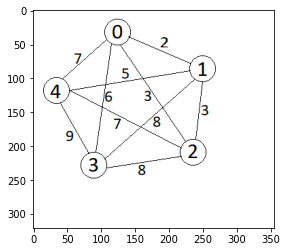

In [264]:
%pylab inline

img = mpimg.imread('fully_connected1.png')
imgplot = plt.imshow(img)
plt.show()

In [265]:
g = Graph([0,1,2,3,4])

g.addEdge(0, 1, 2) 
g.addEdge(1, 0, 2)

g.addEdge(0,2,3)
g.addEdge(2,0,3)

g.addEdge(0, 3, 6) 
g.addEdge(3, 0, 6)

g.addEdge(0, 4, 7) 
g.addEdge(4, 0, 7)

g.addEdge(1, 2, 3) 
g.addEdge(2, 1, 3)

g.addEdge(1, 3, 8) 
g.addEdge(3, 1, 8)
 
g.addEdge(1, 4, 5) 
g.addEdge(4, 1, 5)

g.addEdge(3, 2, 8) 
g.addEdge(2, 3, 8)

g.addEdge(4, 2, 7) 
g.addEdge(2, 4, 7)

g.addEdge(3, 4, 9) 
g.addEdge(4, 3, 9)

generations= 1
path = g.find_optimal_path_using_GA(0,generations) # executes the algorithm
total_cost = g.get_cost(path)
if total_cost:
    print_path(path,0)
    print("total_cost",total_cost)
else:
    print('Did not reach the goal!')

[0, 1, 2, 4, 3]
[0, 4, 1, 2, 3]
[1, 0, 3, 4, 2]
[1, 4, 0, 2, 3]
[0, 4, 2, 1, 3]
[1, 3, 4, 2, 0]
[2, 4, 0, 1, 3]
[2, 4, 3, 0, 1]
[1, 4, 2, 3, 0]
[1, 4, 2, 3, 0]
[2, 1, 4, 3, 0]
[4, 3, 0, 2, 1]
[2, 0, 1, 3, 4]
[4, 2, 3, 1, 0]
[1, 2, 3, 0, 4]
[3, 1, 0, 2, 4]
[0, 3, 1, 4, 2]
[1, 4, 0, 2, 3]
[1, 0, 4, 2, 3]
[1, 0, 4, 2, 3]
26
Best route for generation 1 : [2, 1, 4, 3, 0]
Best cost for generation 1 : 26
=================Path found=================
final path:
0 -> 2
2 -> 1
1 -> 4
4 -> 3
3 -> 0
total_cost 26


In [266]:
g.check_disconnected()

False

In [267]:
nodes=[0,1,2,3,4,5,6,7,8,9]
g = Graph(nodes)
for i in range(10):
    for j in range(10):
        if i>j:
            weight = np.random.randint(20)
            g.addEdge(i,j,weight)
            g.addEdge(j,i,weight)

generations=1500
path = g.find_optimal_path_using_GA(0,generations) # executes the algorithm
total_cost = g.get_cost(path)
if total_cost:
    print_path(path,0)
    print("total_cost",total_cost)
else:
    print('Did not reach the goal!')

[2, 4, 5, 0, 1, 9, 8, 3, 6, 7]
[5, 9, 1, 6, 0, 4, 8, 2, 7, 3]
[6, 5, 3, 0, 1, 8, 9, 4, 7, 2]
[9, 7, 3, 6, 4, 8, 0, 5, 1, 2]
[4, 8, 5, 3, 0, 9, 7, 2, 6, 1]
[1, 8, 4, 3, 7, 9, 2, 5, 0, 6]
[5, 8, 1, 0, 3, 6, 2, 7, 9, 4]
[0, 7, 2, 6, 5, 9, 1, 8, 4, 3]
[7, 3, 1, 4, 5, 2, 0, 9, 8, 6]
[3, 0, 7, 6, 5, 2, 1, 9, 4, 8]
[6, 3, 0, 9, 5, 4, 8, 7, 2, 1]
[0, 1, 4, 3, 2, 5, 6, 8, 9, 7]
[1, 3, 2, 4, 8, 0, 7, 9, 6, 5]
[6, 5, 7, 9, 2, 0, 1, 4, 3, 8]
[0, 6, 4, 7, 8, 2, 9, 3, 1, 5]
[0, 4, 3, 6, 8, 7, 2, 5, 9, 1]
[4, 9, 7, 8, 5, 0, 2, 6, 3, 1]
[8, 7, 1, 9, 2, 4, 0, 5, 3, 6]
[6, 3, 5, 9, 1, 0, 4, 7, 8, 2]
[5, 4, 7, 9, 1, 2, 3, 8, 0, 6]
64
Best route for generation 1 : [1, 3, 2, 4, 8, 0, 7, 9, 6, 5]
Best cost for generation 1 : 64
=================Path found=================
final path:
0 -> 7
7 -> 9
9 -> 6
6 -> 5
5 -> 1
1 -> 3
3 -> 2
2 -> 4
4 -> 8
8 -> 0
total_cost 64
